# Classification of Landsat 8 image with Support Vector Machine

### Satellite Image and tools

The image classified in this project is a subset of a Landsat 8 image taken over the city of Toledo are (at the shoreline of the western basin of Lake Erie, USA). The area consists of three main landcover types, namely vegetation, water, and buildings. The spatial resolution of Landsat 8 imagery is 30 m. From band 1 to band 7 of the satellite image are used for this project.   

Support Vector Machine (SVM) algorithm is used in this project to classify the image. SVM classifies the feature space by finding the optimum hyperplane among pairs of classes. 

Python libraries used in the project are Numpy, Pandas, Matplotlib, Geopandas, Rasterio, Earthpy, Scikit-learn, and Shapely.

 

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import geopandas as gpd
import rasterio as ras
from rasterio.mask import mask
from shapely.geometry import mapping

### import satellite image convert satellite image to a numpy array 

Import the satellite image subset with rasterio. Satellite images consist of several bands (in this case 7) which represent different regions of electromagnetic spectrum. Each band is made of basic units (pixels) consist of numerical values of reflected energy by the features on the Earth's surface. The bands should be converted to a numpy array before analyzing with Python tools.    

In [2]:
# import satellite image subset
erie = ras.open('C:\\Users\\tha87\\Documents\\Python\\Python_data\\Lake_Erie\\Clip_L8\\L8_Subset1.tif')

In [3]:
# convert image to an ndarray
array = erie.read()

# shape of ndarray
array.shape

(7, 543, 572)

### Import point shapefiles of training data

Training data for the study are selected by comparing the image subset with a higher resolution google earth image. All the training ROIs (Region of Interests) are comprised of single pixels. 'Class ID's of the shapefiles are changed to use the points of each shapefile as different classes. 

In [4]:
# import point shapefiles of training and classification data and create geodataframes
water = gpd.read_file('C:\\Users\\tha87\\Documents\\Python\\Python_data\\Lake_Erie\\ROIs\\water.shp')
vegetation = gpd.read_file('C:\\Users\\tha87\\Documents\\Python\\Python_data\\Lake_Erie\\ROIs\\vegetation.shp')
buildings = gpd.read_file('C:\\Users\\tha87\\Documents\\Python\\Python_data\\Lake_Erie\\ROIs\\buildings.shp')

In [5]:
# assign unique 'CLASS_ID's for each class and combine geodataframes to create a single geodataframe 
water['CLASS_ID'].replace('1', '2', inplace= True)
buildings['CLASS_ID'].replace('1', '3', inplace= True)
frames = [vegetation, water, buildings]
joinframe = pd.concat(frames)
joinframe

,CLASS_NAME,CLASS_ID,CLASS_CLRS,geometry
0,vegetation,1,"0,128,0","POLYGON ((297795 4624995, 297795 4624965, 2977..."
1,vegetation,1,"0,128,0","POLYGON ((294375 4624515, 294375 4624485, 2943..."
2,vegetation,1,"0,128,0","POLYGON ((294645 4623435, 294645 4623405, 2946..."
3,vegetation,1,"0,128,0","POLYGON ((306285 4618545, 306285 4618515, 3062..."
4,vegetation,1,"0,128,0","POLYGON ((306975 4617405, 306975 4617375, 3069..."
...,...,...,...,...
25,buildings,3,"255,0,0","POLYGON ((299265 4612305, 299265 4612275, 2992..."
26,buildings,3,"255,0,0","POLYGON ((298785 4612275, 298785 4612245, 2987..."
27,buildings,3,"255,0,0","POLYGON ((293775 4612215, 293775 4612185, 2937..."
28,buildings,3,"255,0,0","POLYGON ((296835 4612185, 296835 4612155, 2968..."


The index column of 'joinframe' consists of three sets of 0 to 29 values. Replaced the index column with numbers from 0 to 89.

In [6]:
 # create a list of numbers from 0 to 89
list = [i for i in range(90)]

# create a dataframe object from 'list'
df_list = pd.DataFrame(list,columns = ['Name'])
df_list

# assign the numbers from 0 to 89 as the index column 
pix_num = df_list['Name']
#del joinframe['pix_num']
gdf= joinframe.set_index(pix_num)
gdf

,CLASS_NAME,CLASS_ID,CLASS_CLRS,geometry
Name,,,,
0,vegetation,1,"0,128,0","POLYGON ((297795 4624995, 297795 4624965, 2977..."
1,vegetation,1,"0,128,0","POLYGON ((294375 4624515, 294375 4624485, 2943..."
2,vegetation,1,"0,128,0","POLYGON ((294645 4623435, 294645 4623405, 2946..."
3,vegetation,1,"0,128,0","POLYGON ((306285 4618545, 306285 4618515, 3062..."
4,vegetation,1,"0,128,0","POLYGON ((306975 4617405, 306975 4617375, 3069..."
...,...,...,...,...
85,buildings,3,"255,0,0","POLYGON ((299265 4612305, 299265 4612275, 2992..."
86,buildings,3,"255,0,0","POLYGON ((298785 4612275, 298785 4612245, 2987..."
87,buildings,3,"255,0,0","POLYGON ((293775 4612215, 293775 4612185, 2937..."


## Create ROIs with the locations of points in the 'gdf' dataframe

Training regions of interests (ROIs) are assigned to single pixels. The pixels corresponding to each point in the 'gdf' geodataframe are selected as training ROIs. 
First, create a list of geometries that represent the pixels selected as training ROIs.

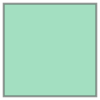

In [7]:
# generate a list of shapely geometries
geoms = gdf.geometry.values

# check a single shapely geometry from the list above
geometry = geoms[0] 
geometry

## Create training feature and labels

Two numpy arrays are created as X (integers) and y(strings). Training features and labels are assigned to the numpy arrays by running a loop.

In [8]:
# Create two empty numpy arrays for training pixel values and target classes as X and y respectively
X = np.array([], dtype=np.int8).reshape(0,7) # pixels for training
y = np.array([], dtype=np.string_) # labels for training

In [9]:
# extract the pixel values within the polygons in whole image
with ras.open('C:\\Users\\tha87\\Documents\\Python\\Python_data\\Lake_Erie\\Clip_L8\\L8_Subset1.tif') as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]
        
        
        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True) 
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[gdf["CLASS_NAME"][index]] * out_image_reshaped.shape[0]) 
        # stack the pixels onto the pixel array
        X = np.vstack((X,out_image_reshaped))

In [10]:
# assign labels for the classes
labels = np.unique(gdf["CLASS_NAME"])
labels

array(['buildings', 'vegetation', 'water'], dtype=object)

In [11]:
# shape of the X array (features)
X.shape

(90, 7)

In [12]:
# shape of the y array (labels)
y.shape

(90,)

### Import and train classifier 

Import SVM classifier from Scikit-learn. Parameters are set to some selected values resulted in meaningful classification results. 

In [13]:
# import classifier algorithm
from sklearn import svm

# fit data to the classifier algorithm
clf = svm.SVC(C=0.1, gamma='scale', kernel='linear')
clf.fit(X, y)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Classify image using the model

The raster image is reshaped as rows, columns, and bands to predict the class of each pixel using the model.
After prediction, the image is reshaped back to a 2D matrix so that the classified image can be visualized. The output from the model is a 2D array of labels. A function is defined and applied to the output array to convert it to a list of integers.

In [14]:
from rasterio.plot import reshape_as_raster, reshape_as_image

# reshape original image into 2d array (nrow * ncol, nband) to use in classification 
reshaped_img = reshape_as_image(array)
reshaped_img.shape

(543, 572, 7)

In [15]:
# predict the class of each pixel
class_prediction = clf.predict(reshaped_img.reshape(-1, 7))

# Reshape the classified array back to a 2D matrix
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)
class_prediction.shape

(543, 572)

In [16]:
# define a function to assign integer values to the labels in the array
def str_class_to_int(class_array):
    class_array[class_array == 'vegetation'] = 1
    class_array[class_array == 'water'] = 2
    class_array[class_array == 'buildings'] = 3
    return(class_array.astype(int))

In [17]:
# convert labels to a numpy array with integers using the function from the last step
class_prediction = str_class_to_int(class_prediction)

### Visualize the classified image

Visualize the original image and classified image together. 

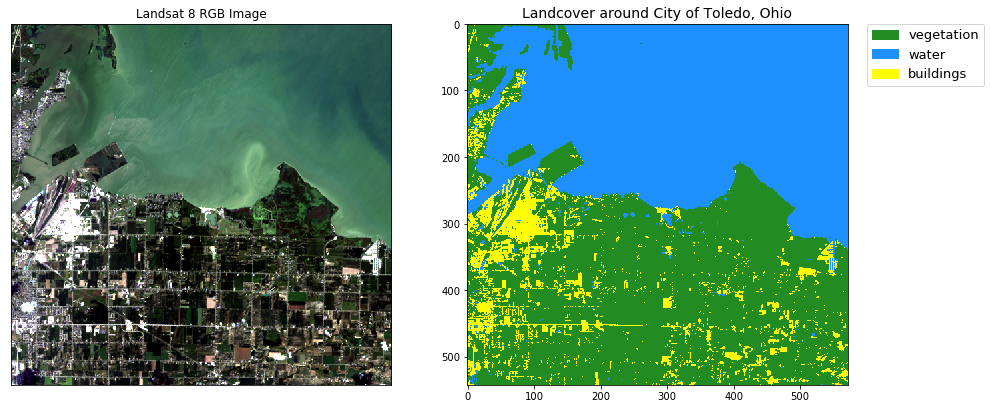

In [18]:
import earthpy.plot as ep
from matplotlib import colors

# show classified image and original image
fig, axs = plt.subplots(1,2,figsize=(15,12))
ep.plot_rgb(array, rgb=(3, 2, 1),ax=axs[0], title='Landsat 8 RGB Image',stretch='lin')


# add a title and legend for the classified image
plt.title('Landcover around City of Toledo, Ohio',fontsize='14')

cmap = colors.ListedColormap(['forestgreen', 'dodgerblue','yellow'])
im = axs[1].imshow(class_prediction, cmap=cmap)
ep.draw_legend(im, titles=["vegetation", "water", "buildings"])
plt.show()

The buildings class includes other built-up features such as roads in the satellite image.

### Next steps

The classification accuracy can be measured by selecting additional pixels as validation ROIs.The optimum classification accuracy can be obtained using the grid search function of Scikit-learn.  